In [ ]:
import gzip
import json
import os
import tempfile

from itertools import product

import ete4
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phylo2vec as p2v
import seaborn as sns

from ete4 import Tree
from phylo2vec.utils.newick import create_label_mapping

img_dir = "img"
ncbi = ete4.NCBITaxa()
cov_taxa_ids = ncbi.get_descendant_taxa("Betacoronavirus")
cov_taxa = ncbi.translate_to_names(cov_taxa_ids)
len(cov_taxa_ids)

603

In [ ]:
dfs = []

bench_dir = ".benchmarks/Linux-CPython-3.10-64bit"

benches = [
    "0022_0.1.12",  # ete4 benchmark
    "0024_ete4", # ete4 benchmark (matrix)
    "0021_0.1.12",  # Original benchmark
    "0033_1.5.0",  # 1.5.0,
    "0023_1.4.0_matrix",  # 1.4.0 sample_matrix,
]
versions = [
    "ete4 v3.1.3",
    "ete4 v3.1.3 - with BLs",
    "phylo2vec v0.1.12 (numba)",
    "phylo2vec v1.5.0 (Rust + PyO3)",
    "phylo2vec v1.4.0 (Rust + PyO3) - with BLs"
]

stat = "mean"

for bench, version in zip(benches, versions):
    with open(f"{bench_dir}/{bench}.json", "r") as f:
        data_i = json.load(f)

    df_i = pd.DataFrame(data_i["benchmarks"])

    df_i["version"] = version

    df_i["param"] = df_i.param.astype(int)

    df_i["name"] = df_i["name"].apply(lambda x: x.replace("test_", "").split("[")[0])

    df_i = pd.concat(
        [df_i.drop("stats", axis=1), pd.json_normalize(df_i["stats"])], axis=1
    )

    df_i["cpu_time"] = df_i["mean"]
    df_i["cpu_stddev"] = df_i["stddev"]

    dfs.append(df_i)

df = pd.concat(dfs, axis=0).reset_index(drop=True)

df.tail()

,group,name,fullname,params,param,extra_info,options,version,min,max,...,iqr_outliers,stddev_outliers,outliers,ld15iqr,hd15iqr,ops,total,iterations,cpu_time,cpu_stddev
85,None,sample_matrix,benchmarks/test_bench.py::test_sample_matrix[6...,{'sample_size': 60000},60000,{},"{'disable_gc': False, 'timer': 'perf_counter',...",phylo2vec v1.4.0 (Rust + PyO3) - with BLs,0.003875,0.004255,...,1,68,68;1,0.003875,0.004255,255.208812,1.014855,1,0.003918,0.000035
86,None,sample_matrix,benchmarks/test_bench.py::test_sample_matrix[7...,{'sample_size': 70000},70000,{},"{'disable_gc': False, 'timer': 'perf_counter',...",phylo2vec v1.4.0 (Rust + PyO3) - with BLs,0.004517,0.004880,...,14,14,14;14,0.004517,0.004716,218.352266,1.016706,1,0.004580,0.000066
87,None,sample_matrix,benchmarks/test_bench.py::test_sample_matrix[8...,{'sample_size': 80000},80000,{},"{'disable_gc': False, 'timer': 'perf_counter',...",phylo2vec v1.4.0 (Rust + PyO3) - with BLs,0.005216,0.005347,...,4,60,60;4,0.005216,0.005331,190.350447,1.171523,1,0.005253,0.000030
88,None,sample_matrix,benchmarks/test_bench.py::test_sample_matrix[9...,{'sample_size': 90000},90000,{},"{'disable_gc': False, 'timer': 'perf_counter',...",phylo2vec v1.4.0 (Rust + PyO3) - with BLs,0.005876,0.006265,...,2,44,44;2,0.005876,0.006046,168.640283,1.168167,1,0.005930,0.000044
89,None,sample_matrix,benchmarks/test_bench.py::test_sample_matrix[1...,{'sample_size': 100000},100000,{},"{'disable_gc': False, 'timer': 'perf_counter',...",phylo2vec v1.4.0 (Rust + PyO3) - with BLs,0.006510,0.007063,...,14,13,13;14,0.006510,0.006672,151.866431,1.172083,1,0.006585,0.000094


In [34]:
ape_versions = ["ape v5.7.1", "ape v5.7.1 with BLs"]
ape_files = [
    ".benchmarks/ape_rtree_equiprob_no_bls.csv",
    ".benchmarks/ape_rtree_equiprob.csv",
]

ape_dfs = []

for file, version in zip(ape_files, ape_versions):
    ape_df = pd.read_csv(file, index_col=0)
    ape_df["version"] = version
    versions.append(version)
    ape_df.rename(columns={"mean": "cpu_time"}, inplace=True)
    ape_df["param"] = ape_df["expr"].apply(
        lambda x: int(float(x[x.find("(") + 1 : x.find(")")].split(",")[0].strip()))
    )
    ape_df["name"] = "sample"
    ape_dfs.append(ape_df)

versions = list(set(versions))
ape_df = pd.concat(ape_dfs, axis=0)

ape_df

,expr,min,lq,cpu_time,median,uq,max,neval,cld,version,param,name
1,"rtree(10000, equiprob = TRUE, br = NULL)",0.053477,0.057926,0.059883,0.060103,0.061814,0.065245,30,a,ape v5.7.1,10000,sample
2,"rtree(20000, equiprob = TRUE, br = NULL)",0.133854,0.140825,0.144884,0.142729,0.145490,0.225409,30,b,ape v5.7.1,20000,sample
3,"rtree(30000, equiprob = TRUE, br = NULL)",0.217153,0.231740,0.240139,0.240929,0.247749,0.262008,30,c,ape v5.7.1,30000,sample
4,"rtree(40000, equiprob = TRUE, br = NULL)",0.343111,0.352446,0.378354,0.364162,0.380911,0.488688,30,d,ape v5.7.1,40000,sample
5,"rtree(50000, equiprob = TRUE, br = NULL)",0.467382,0.497643,0.521811,0.508449,0.526638,0.611096,30,e,ape v5.7.1,50000,sample
6,"rtree(60000, equiprob = TRUE, br = NULL)",0.595650,0.649642,0.680757,0.666933,0.706184,0.806251,30,f,ape v5.7.1,60000,sample
7,"rtree(70000, equiprob = TRUE, br = NULL)",0.809315,0.851354,0.886017,0.883081,0.905146,1.010263,30,g,ape v5.7.1,70000,sample
8,"rtree(80000, equiprob = TRUE, br = NULL)",1.029020,1.054115,1.089527,1.082475,1.125740,1.165223,30,h,ape v5.7.1,80000,sample
9,"rtree(90000, equiprob = TRUE, br = NULL)",1.233469,1.284715,1.325081,1.313553,1.361223,1.450737,30,i,ape v5.7.1,90000,sample
10,"rtree(1e+05, equiprob = TRUE, br = NULL)",1.368655,1.527780,1.574914,1.582897,1.609227,1.724285,30,j,ape v5.7.1,100000,sample


In [35]:
merged_df = pd.concat([df, ape_df], axis=0)

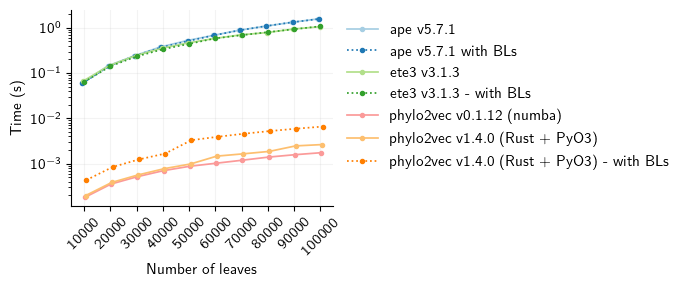

In [156]:
with plt.style.context(".matplotlib/science2.mplstyle"):
    fig, ax = plt.subplots(1, 1, figsize=(7, 3))

    palette = sns.color_palette("Paired").as_hex()

    palette = sns.color_palette([palette[0], palette[1], palette[2], palette[3], palette[4], palette[6], palette[7]])
    linestyles = ["solid", "dotted"] * 2 + ["solid"] + ["solid", "dotted"]

    label = r"sample v"

    name = 'sample'

    sub_df = merged_df.query(f"name.str.contains('{name}')").sort_values(by="version")
    sns.pointplot(
        x="param",
        y="cpu_time",
        hue="version",
        palette=palette,
        data=sub_df,
        linestyles=linestyles,
        markersize=3,
        linewidth=1.25,
        dodge=True,
        # markers=markers,
        ax=ax,
    )

    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # ax.set_title(label)

    ax.set_axisbelow(True)
    ax.grid(alpha=0.15)

    ax.set_xlabel("Number of leaves")
    ax.tick_params(axis="x", rotation=45)
    ax.set_yscale("log")
    # ax.set_ylim(top=2e3)
    ax.set_ylabel("Time (s)")

    sns.despine()
    plt.savefig(f"{img_dir}/sample_benchmark.pdf", bbox_inches="tight", pad_inches=0.1)
    plt.show()

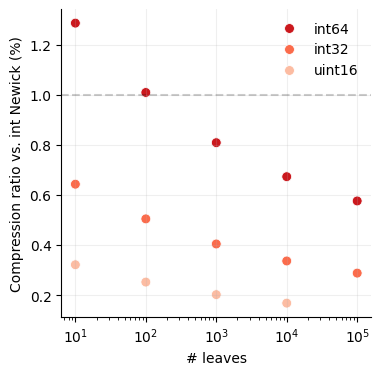

In [ ]:
# fig a: phylo2vec vs. newick with ints
data = {}
for i in np.geomspace(10, 100000, 5):
    v = p2v.sample_vector(int(i))
    newick = p2v.to_newick(v)
    data[int(i)] = {
        "phylo2vec_i64": v.nbytes,
        "phylo2vec_i32": v.astype(np.int32).nbytes,
        "newick": len(newick.encode("utf-8"))
    }

    if i < 32768:
        data[int(i)]["phylo2vec_u16"] = v.astype(np.uint16).nbytes


df = pd.DataFrame.from_dict(data, orient="index").reset_index(names="n_leaves")
df["int64"] = df["phylo2vec_i64"] / df["newick"]
df["int32"] = df["phylo2vec_i32"] / df["newick"]
df["uint16"]  = df["phylo2vec_u16"] / df["newick"]
melted_df = df.melt(id_vars="n_leaves", value_vars=[col for col in df.columns if col.startswith("int") or col.startswith("uint")])
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(
    x="n_leaves",
    y="value",
    hue="variable",
    data=melted_df,
    palette="Reds_r",
    s=50,
    ax=ax
)
ax.legend(frameon=False)
ax.axhline(1.0, color="black", linestyle="dashed", alpha=0.2)
ax.set_ylabel("Compression ratio vs. int Newick (%)")
ax.set_xlabel("# leaves")
ax.set_xscale("log")
ax.grid(alpha=0.2)
sns.despine()
plt.savefig(f"{img_dir}/p2v_vs_nwk_int.pdf", format="pdf", pad_inches=0.1, bbox_inches="tight")
plt.show()

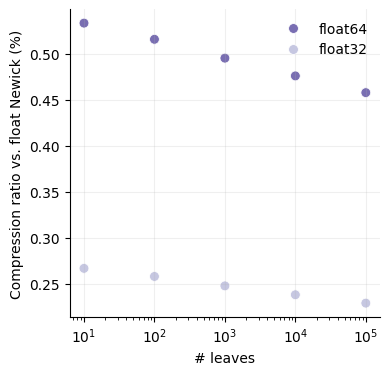

In [6]:
# fig b: phylo2vec vs. newick with floats
data = {}
for i in np.geomspace(10, 100000, 5):
    m = p2v.sample_matrix(int(i))
    newick = p2v.to_newick(m)
    data[int(i)] = {
        "phylo2vec_f64": m.nbytes,
        "phylo2vec_f32": m.astype(np.float32).nbytes,
        "newick": len(newick.encode("utf-8")),
    }

df = pd.DataFrame.from_dict(data, orient="index").reset_index(names="n_leaves")
df["float64"] = df["phylo2vec_f64"] / df["newick"]
df["float32"] = df["phylo2vec_f32"] / df["newick"]
melted_df = df.melt(
    id_vars="n_leaves",
    value_vars=[
        col for col in df.columns if col.startswith("float")
    ],
)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(
    x="n_leaves", y="value", hue="variable", data=melted_df, palette="Purples_r", s=50, ax=ax
)
ax.legend(frameon=False)
# ax.axhline(1.0, color="black", linestyle="dashed", alpha=0.2)
ax.set_ylabel("Compression ratio vs. float Newick (%)")
ax.set_xlabel("# leaves")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(alpha=0.2)
sns.despine()
plt.savefig(f"{img_dir}/p2v_vs_nwk_float.pdf", format="pdf", pad_inches=0.1, bbox_inches="tight")
plt.show()

10
20
30
40
50
60
70
80
90
100


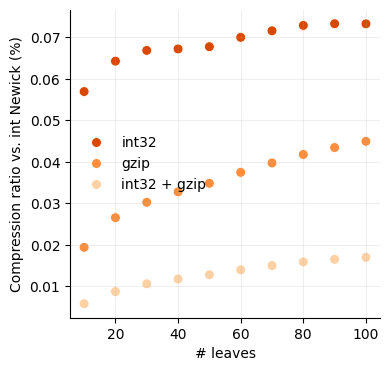

In [ ]:
# fig c: phylo2vec vs. .trees file for topologies
data = {}
for i in np.linspace(10, 100, 10, dtype=np.int64):
    newicks = []
    vs = []
    for j in range(10000):
        tr = Tree()
        tr.populate(i, names_library=cov_taxa)
        newick = tr.write(format=9)
        newicks.append(newick)
        newick_int, mapping = create_label_mapping(newick)
        vs.append(p2v.from_newick(newick_int))

    with tempfile.NamedTemporaryFile(mode='w', suffix=".trees", delete=False) as f:
        f.write("\n".join(newicks))
    tmp_newick_path = f.name

    newick_size = os.path.getsize(tmp_newick_path)
    with tempfile.NamedTemporaryFile(mode='w', suffix=".p2v", delete=False) as fv:
        with h5py.File(fv.name, "w") as h5f:
            h5f.create_dataset("v", data=np.array(vs).astype(np.uint16))
            h5f.create_dataset("mapping", data=json.dumps(mapping))

    tmp_h5_path = fv.name

    # Compress both with gzip
    with open(tmp_newick_path, 'rb') as f_in:
        with gzip.open(tmp_newick_path + '.gz', 'wb') as f_out:
            f_out.write(f_in.read())

    with open(tmp_h5_path, 'rb') as f_in:
        with gzip.open(tmp_h5_path + '.gz', 'wb') as f_out:
            f_out.write(f_in.read())

    # Get compressed sizes
    newick_gz_size = os.path.getsize(tmp_newick_path + '.gz')
    hdf5_gz_size = os.path.getsize(tmp_h5_path + '.gz')

    v_size = os.path.getsize(fv.name)

    os.unlink(tmp_newick_path)  # Clean up
    os.unlink(tmp_h5_path)  # Clean up
    os.remove(f"{tmp_newick_path}.gz")
    os.remove(f"{tmp_h5_path}.gz")

    data[i] = {
        "newick": newick_size,
        "phylo2vec_i32": v_size,
        "newick_gz": newick_gz_size,
        "phylo2vec_i32_gz": hdf5_gz_size,
    }

    print(i)

df = pd.DataFrame.from_dict(data, orient="index").reset_index(names="n_leaves")
df["int32"] = df["phylo2vec_i32"] / df["newick"]
df["gzip"] = df["newick_gz"] / df["newick"]
df["int32 + gzip"] = df["phylo2vec_i32_gz"] / df["newick"]
melted_df = df.melt(
    id_vars="n_leaves",
    value_vars=[col for col in df.columns if col.startswith("int") or col.startswith("gzip")],
)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(
    x="n_leaves", y="value", hue="variable", data=melted_df, palette="Oranges_r", s=50, ax=ax
)
ax.legend(frameon=False)
ax.set_ylabel("Compression ratio vs. int Newick (%)")
ax.set_xlabel("# leaves")
ax.grid(alpha=0.2)
sns.despine()
plt.savefig(f"{img_dir}/p2v_vs_nwk_int_files.pdf", format="pdf", pad_inches=0.1, bbox_inches="tight")
plt.show()

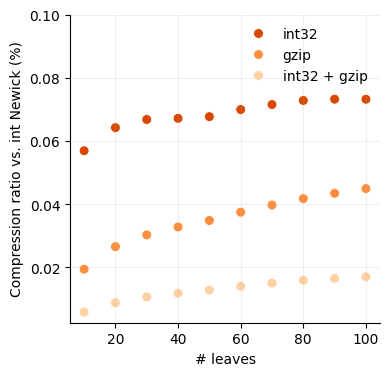

In [85]:
df = pd.DataFrame.from_dict(data, orient="index").reset_index(names="n_leaves")
df["int32"] = df["phylo2vec_i32"] / df["newick"]
df["gzip"] = df["newick_gz"] / df["newick"]
df["int32 + gzip"] = df["phylo2vec_i32_gz"] / df["newick"]
melted_df = df.melt(
    id_vars="n_leaves",
    value_vars=[
        col for col in df.columns if col.startswith("int") or col.startswith("gzip")
    ],
)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(
    x="n_leaves",
    y="value",
    hue="variable",
    data=melted_df,
    palette="Oranges_r",
    s=50,
    ax=ax,
)
ax.set_ylabel("Compression ratio vs. int Newick (%)")
ax.set_xlabel("# leaves")
ax.grid(alpha=0.2)
sns.despine()
ax.legend(frameon=False)
ax.set_ylim(top=0.1)
plt.savefig(
    f"{img_dir}/p2v_vs_nwk_int_files.pdf",
    format="pdf",
    pad_inches=0.1,
    bbox_inches="tight",
)
plt.show()

10
20
30
40
50
60
70
80
90
100


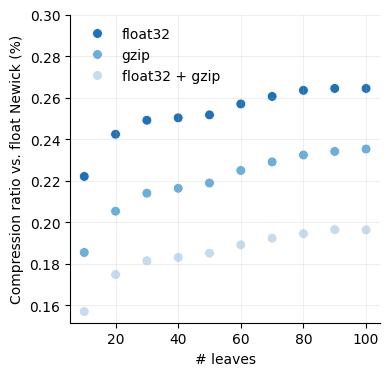

In [86]:
# fig d: phylo2vec vs. .trees file for trees with BLs
data = {}
for i in np.linspace(10, 100, 10, dtype=np.int64):
    newicks = []
    ms = []
    for j in range(10000):
        tr = Tree()
        tr.populate(i, names_library=cov_taxa, random_branches=True)
        newick = tr.write(format=1)
        newicks.append(newick)
        newick_float, mapping = create_label_mapping(newick)
        ms.append(p2v.from_newick(newick_float))

    with tempfile.NamedTemporaryFile(mode="w", delete=False) as f:
        f.write("\n".join(newicks))
    tmp_newick_path = f.name

    newick_size = os.path.getsize(tmp_newick_path)
    with tempfile.NamedTemporaryFile(mode="w", delete=False) as fv:
        with h5py.File(fv.name, "w") as h5f:
            h5f.create_dataset("m", data=np.array(ms).astype(np.float32))
            h5f.create_dataset("mapping", data=json.dumps(mapping))

    tmp_h5_path = fv.name

    # Compress both with gzip
    with open(tmp_newick_path, "rb") as f_in:
        with gzip.open(tmp_newick_path + ".gz", "wb") as f_out:
            f_out.write(f_in.read())

    with open(tmp_h5_path, "rb") as f_in:
        with gzip.open(tmp_h5_path + ".gz", "wb") as f_out:
            f_out.write(f_in.read())

    # Get compressed sizes
    newick_gz_size = os.path.getsize(tmp_newick_path + ".gz")
    hdf5_gz_size = os.path.getsize(tmp_h5_path + ".gz")

    v_size = os.path.getsize(fv.name)

    os.unlink(tmp_newick_path)  # Clean up
    os.unlink(tmp_h5_path)  # Clean up
    os.remove(f"{tmp_newick_path}.gz")
    os.remove(f"{tmp_h5_path}.gz")

    data[i] = {
        "newick": newick_size,
        "phylo2vec_f32": v_size,
        "newick_gz": newick_gz_size,
        "phylo2vec_f32_gz": hdf5_gz_size,
    }

    print(i)

df = pd.DataFrame.from_dict(data, orient="index").reset_index(names="n_leaves")
df["float32"] = df["phylo2vec_f32"] / df["newick"]
df["gzip"] = df["newick_gz"] / df["newick"]
df["float32 + gzip"] = df["phylo2vec_f32_gz"] / df["newick"]
melted_df = df.melt(
    id_vars="n_leaves",
    value_vars=[col for col in df.columns if col.startswith("float32") or col.startswith("gzip")],
)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(
    x="n_leaves",
    y="value",
    hue="variable",
    data=melted_df,
    palette="Blues_r",
    s=50,
    ax=ax,
)
ax.legend(frameon=False)
ax.set_ylabel("Compression ratio vs. float Newick (%)")
ax.set_xlabel("# leaves")
ax.grid(alpha=0.2)
ax.set_ylim(top=0.3)
sns.despine()
plt.savefig(
    f"{img_dir}/p2v_vs_nwk_float_files.pdf",
    format="pdf",
    pad_inches=0.1,
    bbox_inches="tight",
)
plt.show()

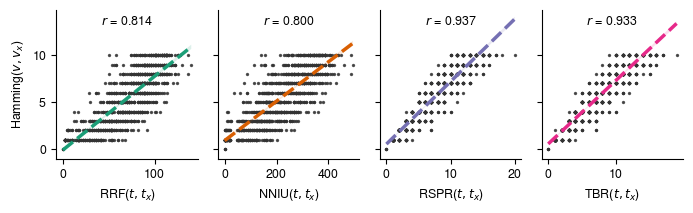

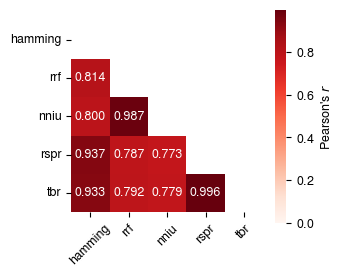

In [ ]:
metrics = pd.read_csv(
    "tmp/compare_metrics_from_multi_moves_10_0119.csv", index_col=0
)  # .set_index("step")
rows = ["hamming"]
cols = ["rrf", "nniu", "rspr", "tbr"]

palette = sns.color_palette("Dark2", n_colors=len(rows) * len(cols))

with plt.style.context("joss/.matplotlib/science2.mplstyle"):
    fig, axs = plt.subplots(1, 4, figsize=(7, 2.2), sharey=True)

    axs = axs.ravel()

    for i, (r, c) in enumerate(product(rows, cols)):
        sns.regplot(
            x=c,
            y=r,
            data=metrics,
            ax=axs[i],
            line_kws=dict(color=palette[i], linestyle="dashed", linewidth=2.5),
            scatter_kws={'s':2},
            n_boot=5000,
            color=".2",
            # fill=True
        )
        if i == 0:
            axs[i].set_ylabel("Hamming($v,v_x$)")
        else:
            axs[i].set_ylabel("")
        axs[i].set_xlabel(f"{c.upper()}($t,t_x$)")
        corrcoef = np.corrcoef(metrics[c], metrics[r])[0, 1]
        axs[i].text(0.5, 0.9, f"$r$ = {corrcoef:.3f}", transform=axs[i].transAxes, ha="center")
        # axs[i].legend(["", f"$r$ = {corrcoef:.3f}"], loc="center right", frameon=False, bbox_to_anchor=(1, 1.05))
    sns.despine()
    fig.tight_layout()
    plt.savefig(f"{img_dir}/compare_metrics_from_v.pdf", pad_inches=0.1, bbox_inches="tight")
    plt.savefig(
        f"{img_dir}/compare_metrics_from_v.png", pad_inches=0.1, bbox_inches="tight", dpi=300
    )
    plt.show()

    metrics_corr = metrics.loc[:, rows + cols].corr()
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
    sns.heatmap(
        metrics_corr,
        cmap="Reds",
        vmin=0,
        annot=True,
        square=True,
        fmt=".3f",
        mask=np.triu(np.ones_like(metrics_corr)),
        cbar_kws={"label": "Pearson's $r$", "shrink": 0.66},
        ax=ax
    )
    ax.tick_params(axis="x", labelrotation=45)
    ax.tick_params(axis="y", labelrotation=0)
    plt.savefig(
        f"{img_dir}/compare_metrics_from_v_corr.pdf", pad_inches=0.1, bbox_inches="tight"
    )
    plt.savefig(
        f"{img_dir}/compare_metrics_from_v_corr.png",
        pad_inches=0.1,
        bbox_inches="tight",
        dpi=300
    )
    plt.show()

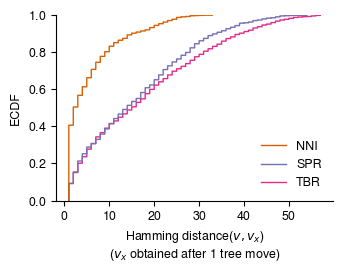

In [39]:
with plt.style.context("joss/.matplotlib/science2.mplstyle"):

    metrics = pd.read_csv("tmp/compare_metrics_from_tree_moves_0119.csv", index_col=0).melt()
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.8))
    g = sns.ecdfplot(
        x="value",
        hue="variable",
        data=metrics,
        palette=sns.color_palette("Dark2", n_colors=4).as_hex()[1:],
        ax=ax
    )
    ax.set_xlabel("Hamming distance($v,v_x$)\n($v_x$ obtained after 1 tree move)")
    ax.set_ylabel("ECDF")
    g.get_legend().set_title(None)
    # Apply upper case to each legend
    for text in g.get_legend().get_texts():
        text.set_text(text.get_text().upper())
    sns.despine()
    plt.savefig(
        f"{img_dir}/compare_metrics_from_moves_0119.pdf",
        pad_inches=0.1,
        bbox_inches="tight",
    )

    plt.show()

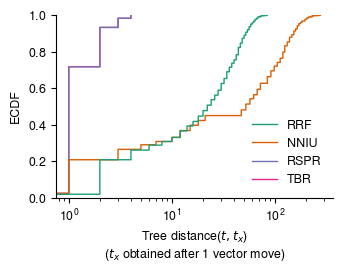

In [34]:
with plt.style.context("joss/.matplotlib/science2.mplstyle"):
    metrics = (
        pd.read_csv("tmp/compare_metrics_from_v_moves_0119.csv", index_col=0)
        .drop(["hamming", "rf"], axis=1)
        .melt()
    )
    # print(metrics.value)
    # Add a bit of jitter to see overlapping points
    # metrics.value = metrics.value + np.random.normal(0, 0.7, size=len(metrics)).astype(int)

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.8))
    g = sns.ecdfplot(x="value", hue="variable", data=metrics, palette="Dark2", ax=ax)
    ax.set_xlabel("Tree distance($t,t_x$)\n($t_x$ obtained after 1 vector move)")
    ax.set_ylabel("ECDF")
    # ax.set_xlim(left=0)
    ax.set_xscale("log")
    g.get_legend().set_title(None)
    # Apply upper case to each legend
    for text in g.get_legend().get_texts():
        text.set_text(text.get_text().upper())
    plt.savefig(
        f"{img_dir}/compare_metrics_from_v_single.pdf",
        pad_inches=0.1,
        bbox_inches="tight",
    )
    sns.despine()

    plt.show()

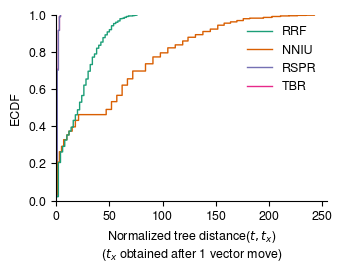

In [41]:
with plt.style.context("joss/.matplotlib/science2.mplstyle"):
    metrics = (
        pd.read_csv("tmp/compare_metrics_from_v_moves_0119.csv", index_col=0)
        .drop(["hamming", "rf"], axis=1)
        .melt()
    )
    # print(metrics.value)
    # Add a bit of jitter to see overlapping points
    # metrics.value = metrics.value # + np.random.normal(0, 0.7, size=len(metrics)).astype(
    #     int
    # )

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.8))
    g = sns.ecdfplot(x="value", hue="variable", data=metrics, palette="Dark2", ax=ax)
    ax.set_xlabel("Normalized tree distance($t,t_x$)\n($t_x$ obtained after 1 vector move)")
    ax.set_ylabel("ECDF")
    # ax.set_xscale("log")
    ax.set_xlim(left=0)
    g.get_legend().set_title(None)
    # Apply upper case to each legend
    for text in g.get_legend().get_texts():
        text.set_text(text.get_text().upper())
    sns.despine()
    plt.savefig(
        f"{img_dir}/compare_metrics_from_v_single_jittered_0119.pdf",
        pad_inches=0.1,
        bbox_inches="tight",
    )

    plt.show()